In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import random_split
import torchvision.datasets as dset
import torchvision.transforms as T

import glob
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image as I

In [2]:
TRAINING_DATA_PATH = '../input/state-farm-distracted-driver-detection/imgs/train'

transform = T.Compose([T.Resize((224,224)), T.ToTensor()])
dd_train_data = dset.ImageFolder(TRAINING_DATA_PATH, transform=transform)

print(len(dd_train_data))
print(dd_train_data.classes)

num_classes = len(dd_train_data.classes)

22424
['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']


In [19]:
train_set_size = int(len(dd_train_data) * 0.8)
val_set_size = len(dd_train_data) - train_set_size

train_batches = train_set_size //32
val_batches = val_set_size //32

train_set, val_set = random_split(dd_train_data,[train_set_size,val_set_size])

loader_train = DataLoader(train_set, batch_size=32)
loader_val = DataLoader(val_set, batch_size=32)

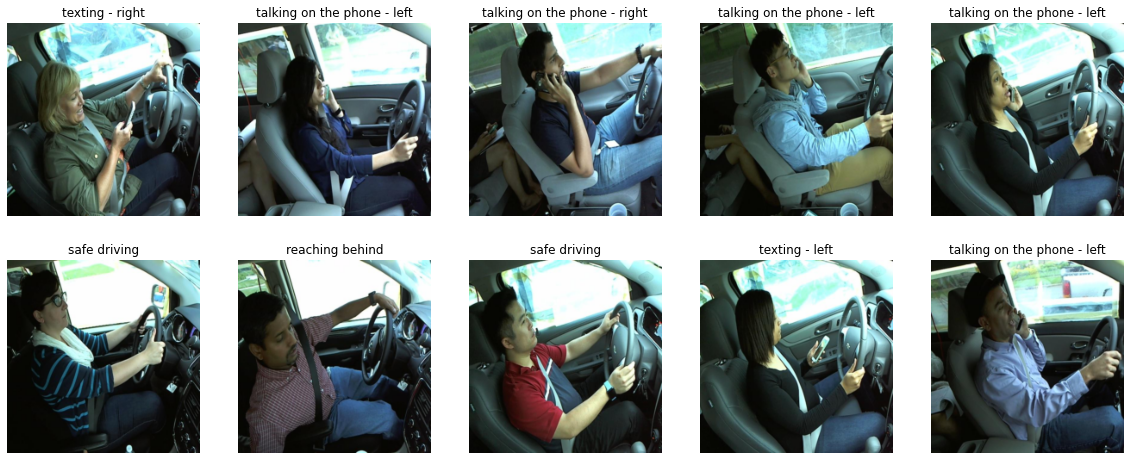

In [4]:
labels_map = {
    0: 'safe driving',
    1: 'texting - right',
    2: 'talking on the phone - right',
    3: 'texting - left',
    4: 'talking on the phone - left',
    5: 'operating the radio',
    6: 'drinking',
    7: 'reaching behind',
    8: 'hair and makeup',
    9: 'talking to passenger',
}
toPIL = T.ToPILImage()
figure = plt.figure(figsize=(20, 8))
cols, rows = 5,2
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_set), size=(1,)).item()
    img, label = dd_train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    pil_img = toPIL(img)
    plt.imshow(pil_img)
plt.show()

In [5]:
torch.cuda.is_available()

True

In [6]:
def flatten(x, start_dim=1, end_dim=-1):
    return x.flatten(start_dim=start_dim, end_dim=end_dim)

In [7]:
class MyConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 16, 3, padding=1)
        
        self.conv3 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv4 = nn.Conv2d(32, 32, 3, padding=1)
        
        self.conv5 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv6 = nn.Conv2d(64, 64, 3, padding=1)
        self.conv7 = nn.Conv2d(64, 64, 3, padding=1)
        
        self.conv8 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv9 = nn.Conv2d(128, 128, 3, padding=1)
        self.conv10 = nn.Conv2d(128, 128, 3, padding=1)
        
        self.conv11 = nn.Conv2d(128, 128, 3, padding=1)
        self.conv12 = nn.Conv2d(128, 128, 3, padding=1)
        self.conv13 = nn.Conv2d(128, 128, 3, padding=1)
        
        self.fc1 = nn.Linear(6272, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, num_classes)

        nn.init.kaiming_normal_(self.conv1.weight)
        nn.init.kaiming_normal_(self.conv2.weight)
        nn.init.kaiming_normal_(self.conv3.weight)
        nn.init.kaiming_normal_(self.conv4.weight)
        nn.init.kaiming_normal_(self.conv5.weight)
        nn.init.kaiming_normal_(self.conv6.weight)
        nn.init.kaiming_normal_(self.conv7.weight)
        nn.init.kaiming_normal_(self.conv8.weight)
        nn.init.kaiming_normal_(self.conv9.weight)
        nn.init.kaiming_normal_(self.conv10.weight)
        nn.init.kaiming_normal_(self.conv11.weight)
        nn.init.kaiming_normal_(self.conv12.weight)
        nn.init.kaiming_normal_(self.conv13.weight)
        nn.init.kaiming_normal_(self.fc1.weight)
        nn.init.kaiming_normal_(self.fc2.weight)
        nn.init.kaiming_normal_(self.fc3.weight)
        nn.init.zeros_(self.conv1.bias)
        nn.init.zeros_(self.conv2.bias)
        nn.init.zeros_(self.conv3.bias)
        nn.init.zeros_(self.conv4.bias)
        nn.init.zeros_(self.conv5.bias)
        nn.init.zeros_(self.conv6.bias)
        nn.init.zeros_(self.conv7.bias)
        nn.init.zeros_(self.conv8.bias)
        nn.init.zeros_(self.conv9.bias)
        nn.init.zeros_(self.conv10.bias)
        nn.init.zeros_(self.conv11.bias)
        nn.init.zeros_(self.conv12.bias)
        nn.init.zeros_(self.conv13.bias)
        nn.init.zeros_(self.fc1.bias)
        nn.init.zeros_(self.fc2.bias)
        nn.init.zeros_(self.fc3.bias)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(F.relu(self.conv4(x)), (2, 2))
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = F.max_pool2d(F.relu(self.conv7(x)), (2, 2))
        x = F.relu(self.conv8(x))
        x = F.relu(self.conv9(x))
        x = F.max_pool2d(F.relu(self.conv10(x)), (2, 2))
        x = F.relu(self.conv11(x))
        x = F.relu(self.conv12(x))
        x = F.max_pool2d(F.relu(self.conv13(x)), (2, 2))
        x = flatten(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        scores = self.fc3(x)
        return scores

In [8]:
def test_MyConvNet():
    x = torch.zeros((32, 3, 224, 224), dtype=torch.float)
    model = MyConvNet()
    scores = model(x)
    print(model) 
    print('Output size:', list(scores.size())) # Should be 32x10
test_MyConvNet()

MyConvNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv9): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv11): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv12): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv13): Conv2d(128, 128, kernel_size=(3, 3), strid

In [36]:
def check_accuracy(loader, model):   
    num_correct = 0
    num_samples = 0
    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device='cuda', dtype=torch.float) 
            y = y.to(device='cuda', dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
    return acc

def check_val_acc_and_loss(model):
    loss_sum = 0
    num_correct = 0
    num_samples = 0
    model.eval()
    with torch.no_grad():
        for x,y in loader_val:
            x = x.to(device='cuda', dtype=torch.float)
            y = y.to(device='cuda', dtype=torch.long)
            scores = model(x)
            loss = F.cross_entropy(scores, y)
            loss_sum += loss.item()
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        avg_loss = loss_sum / val_batches
    return acc, avg_loss

In [37]:
def adjust_learning_rate(optimizer, lrd, epoch, schedule):
    if epoch in schedule:
        for param_group in optimizer.param_groups:
            print('lr decay from {} to {}'.format(param_group['lr'], param_group['lr'] * lrd))
            param_group['lr'] *= lrd

def train(model, optimizer, epochs=1, learning_rate_decay=.1, schedule=[]):
    model = model.to(device='cuda')
    num_iters = epochs * len(loader_train)
    print_every = 100
    num_prints = num_iters // print_every + 1
    
    val_acc_history = torch.zeros(num_prints, dtype=torch.float)
    train_acc_history = torch.zeros(num_prints, dtype=torch.float)
    train_loss_history = torch.zeros(num_prints, dtype=torch.float)
    val_loss_history = torch.zeros(num_prints, dtype=torch.float)
    for e in range(epochs):
        num_correct = 0
        num_samples = 0
        
        adjust_learning_rate(optimizer, learning_rate_decay, e, schedule)
    
        for t, (x, y) in enumerate(loader_train):
            model.train()
            x = x.to(device='cuda', dtype=torch.float)
            y = y.to(device='cuda', dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)
            
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            tt = t + e * len(loader_train)

            if (tt % print_every == 0 or t == len(loader_train)-1):
                print('Epoch %d, Iteration %d' % (e, tt))
                val_acc, val_loss = check_val_acc_and_loss(model)
                val_acc_history[tt // print_every] = val_acc
                val_loss_history[tt // print_every] = val_loss
                
                train_acc = float(num_correct) / num_samples
                train_acc_history[tt // print_every] = train_acc
                train_loss_history[tt // print_every] = loss.item()
                print('training loss = %.4f, val loss = %.4f' % (loss.item(), val_loss))
                print('training acc = %.4f, val acc = %.4f' % (train_acc, val_acc))
                      
    return val_acc_history, train_acc_history, train_loss_history, val_loss_history

In [38]:
learning_rate = 1e-4
weight_decay = 1e-4
epochs = 10
lrd = 1
decay_schedule = []

model = MyConvNet()
model = model.to(device='cuda')
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
val_acc_history, train_acc_history, train_loss_history, val_loss_history = train(model, optimizer, epochs, lrd, decay_schedule)

Epoch 0, Iteration 0
training loss = 2.2869, val loss = 3.1764
training acc = 0.1562, val acc = 0.1278
Epoch 0, Iteration 100
training loss = 1.1653, val loss = 0.9801
training acc = 0.3447, val acc = 0.6664
Epoch 0, Iteration 200
training loss = 0.5285, val loss = 0.3638
training acc = 0.5594, val acc = 0.8952
Epoch 0, Iteration 300
training loss = 0.1025, val loss = 0.2218
training acc = 0.6768, val acc = 0.9405
Epoch 0, Iteration 400
training loss = 0.1504, val loss = 0.2230
training acc = 0.7417, val acc = 0.9402
Epoch 0, Iteration 500
training loss = 0.3334, val loss = 0.1495
training acc = 0.7831, val acc = 0.9583
Epoch 0, Iteration 560
training loss = 0.0597, val loss = 0.1278
training acc = 0.8019, val acc = 0.9690
Epoch 1, Iteration 600
training loss = 0.1613, val loss = 0.0876
training acc = 0.9547, val acc = 0.9757
Epoch 1, Iteration 700
training loss = 0.0329, val loss = 0.1054
training acc = 0.9647, val acc = 0.9728
Epoch 1, Iteration 800
training loss = 0.0081, val loss =

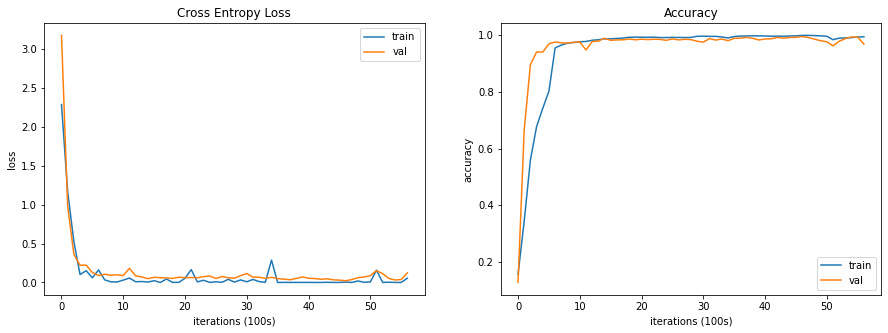

In [45]:
figure = plt.figure(figsize=(15,5))
figure.add_subplot(1, 2, 1)
plt.plot(train_loss_history, label='train')
plt.plot(val_loss_history, label='val')
plt.legend(['train','val'], loc='upper right')
plt.xlabel('iterations (100s)')
plt.ylabel('loss')
plt.title('Cross Entropy Loss')
figure.add_subplot(1, 2, 2)
plt.plot(train_acc_history, label='train')
plt.plot(val_acc_history, label='val')
plt.legend(['train','val'], loc='lower right')
plt.xlabel('iterations (100s)')
plt.ylabel('accuracy')
plt.title('Accuracy')
plt.show()

In [46]:
class TestDataset(Dataset):
    def __init__(self, path, transform=None):
        self.image_paths = glob.glob(path + '*.jpg')
        self.transform = transform

    def __getitem__(self, index):
        x = I.open(self.image_paths[index])
        if self.transform is not None:
            x = self.transform(x)

        return x, self.image_paths[index].split('/')[-1]

    def __len__(self):
        return len(self.image_paths)

In [47]:
TEST_DATA_PATH = '../input/state-farm-distracted-driver-detection/imgs/test/'

dd_test_data = TestDataset(TEST_DATA_PATH, transform=transform)
loader_test = DataLoader(dd_test_data, batch_size=32)

print(len(dd_test_data))
dd_test_data[0] # returns image and file name

79726


(tensor([[[0.0549, 0.0549, 0.0549,  ..., 0.5255, 0.5843, 0.6353],
          [0.0588, 0.0588, 0.0588,  ..., 0.4902, 0.5137, 0.5529],
          [0.0706, 0.0706, 0.0706,  ..., 0.4745, 0.4941, 0.5020],
          ...,
          [0.0824, 0.0784, 0.0784,  ..., 0.1373, 0.2314, 0.2745],
          [0.0824, 0.0784, 0.0784,  ..., 0.1098, 0.2275, 0.2667],
          [0.0824, 0.0784, 0.0745,  ..., 0.0902, 0.2157, 0.2549]],
 
         [[0.0588, 0.0588, 0.0588,  ..., 0.6667, 0.7294, 0.7804],
          [0.0588, 0.0588, 0.0588,  ..., 0.6471, 0.6706, 0.7098],
          [0.0588, 0.0588, 0.0588,  ..., 0.6431, 0.6588, 0.6667],
          ...,
          [0.1059, 0.1020, 0.1020,  ..., 0.1490, 0.2784, 0.3451],
          [0.1137, 0.1098, 0.1059,  ..., 0.1216, 0.2706, 0.3333],
          [0.1176, 0.1137, 0.1098,  ..., 0.0980, 0.2588, 0.3216]],
 
         [[0.0353, 0.0353, 0.0353,  ..., 0.6196, 0.6745, 0.7176],
          [0.0392, 0.0392, 0.0392,  ..., 0.5961, 0.6157, 0.6510],
          [0.0471, 0.0471, 0.0471,  ...,

In [48]:
softmax = nn.Softmax(dim=1)
submission_data = []
with torch.no_grad():
    for inputs, filenames in loader_test:
        inputs = inputs.to('cuda')
        outputs = model(inputs)
        outputs = softmax(outputs)
        outputs = outputs.tolist()
        for filename, output in zip(filenames, outputs):
            row = [filename]
            row.extend(output)
            submission_data.append(row)
    df = pd.DataFrame(data=submission_data, dtype='object',
                 columns=['img', 'c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9'])
    df = df.sort_values(by=['img'])
    df.to_csv('distracted_driver_submission1.csv', index=False, line_terminator='\n')